In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
#pm.help()
#pm.reset()
pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()
df_jo_cp['cr_received_date'] = df_jo_cp.cash_request_received_date


In [2]:
df = pm.df('df_jall')
#df = df_jo_cp

#display(df)
#display(df[~df.Mes_created_at.isna()])

# Tiempo que tarda en recibir el dinero el usuario desde la primera accion.
# cr_received_date  (cash_request_received_date) = ??
df['to_receive_ini'] = df.cr_received_date-df.created_at

# Tiempo que tarda en recibir el dinero el usuario desde que se envia (demora entre bancos).
df['to_receive_bank'] = df.cash_request_received_date-df.send_at

# Tiempo que la empresa recupera el dinero desde la primera accion.
df['to_reimbur'] = df.reimbursement_date-df.created_at

# Tiempo en el que la emprera realmente ha prestado el dinero
df['to_reimbur_cash'] = df.reimbursement_date-df.send_at

# Tiempo que la empresa presta el dinero.
df['to_end'] = df.reimbursement_date-df.money_back_date

#* Demora:
#df['to_delay'] = df.money_back_date-df.reimbursement_date

# En funcion del tipo instant o regular:
# TransfType: instant send_at - created_at =? 0 dias
# TransfType: regular send_at - created_at =? 7 dias
df['to_send'] = df.send_at-df.created_at

df.info()
display(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32094 non-null  int64          
 1   amount                      32094 non-null  float64        
 2   stat_cr                     32094 non-null  object         
 3   created_at                  32094 non-null  datetime64[ns] 
 4   updated_at_x                32094 non-null  datetime64[ns] 
 5   user_id                     32094 non-null  int64          
 6   active                      32094 non-null  int64          
 7   moderated_at                21759 non-null  datetime64[ns] 
 8   reimbursement_date          32094 non-null  datetime64[ns] 
 9   cash_request_received_date  24149 non-null  datetime64[ns] 
 10  money_back_date             23917 non-null  datetime64[ns] 
 11  transfer_type               32094 non-nul

,id_cr,amount,stat_cr,created_at,updated_at_x,user_id,active,moderated_at,reimbursement_date,cash_request_received_date,...,to_date,charge_moment,fee,cr_received_date,to_receive_ini,to_receive_bank,to_reimbur,to_reimbur_cash,to_end,to_send
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.407830,804,1,2019-12-11 16:47:42.405646,2020-01-09 19:05:21.596363,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,29 days 23:59:59.999490,NaT,NaT,NaT
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054,231,1,2019-12-11 14:24:22.897988,2020-01-09 19:50:12.347780,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,30 days 00:00:00,NaT,NaT,NaT
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773,191,1,2019-12-11 09:46:59.777728,2020-01-09 19:13:35.825041,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,29 days 23:59:59.999581,NaT,NaT,NaT
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163,761,1,2019-12-18 14:26:18.128407,2020-01-09 19:16:10.879606,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,29 days 23:59:59.999434,NaT,NaT,NaT
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.340080,7686,1,2020-05-07 09:21:55.320193,2020-06-05 22:00:00.000000,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,30 days 12:00:21.122624,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32089,22357,100.0,money_back,2020-10-20 07:58:04.006937,2021-02-05 12:19:30.656816,82122,1,NaT,2021-02-05 11:00:00.000000,2020-10-21,...,NaT,after,5.0,2020-10-21,0 days 16:01:55.993063,0 days 16:01:45.828447,108 days 03:01:55.993063,108 days 03:01:45.828447,-1 days +22:40:29.373711,0 days 00:00:10.164616
32090,20256,100.0,money_back,2020-10-10 05:40:55.700422,2021-02-05 13:14:19.707627,64517,1,NaT,2021-02-05 11:00:00.000000,2020-10-12,...,2020-12-07 11:00:00,before,5.0,2020-10-12,1 days 18:19:04.299578,1 days 18:18:36.631637,118 days 05:19:04.299578,118 days 05:18:36.631637,-1 days +21:45:40.310094,0 days 00:00:27.667941
32091,20256,100.0,money_back,2020-10-10 05:40:55.700422,2021-02-05 13:14:19.707627,64517,1,NaT,2021-02-05 11:00:00.000000,2020-10-12,...,NaT,after,5.0,2020-10-12,1 days 18:19:04.299578,1 days 18:18:36.631637,118 days 05:19:04.299578,118 days 05:18:36.631637,-1 days +21:45:40.310094,0 days 00:00:27.667941
32092,19886,100.0,direct_debit_sent,2020-10-08 14:16:52.155661,2021-01-05 15:45:52.645536,44867,1,NaT,2021-02-05 11:00:00.000000,2020-10-10,...,2020-12-06 11:00:00,before,5.0,2020-10-10,1 days 09:43:07.844339,1 days 09:42:55.473861,119 days 20:43:07.844339,119 days 20:42:55.473861,NaT,0 days 00:00:12.370478


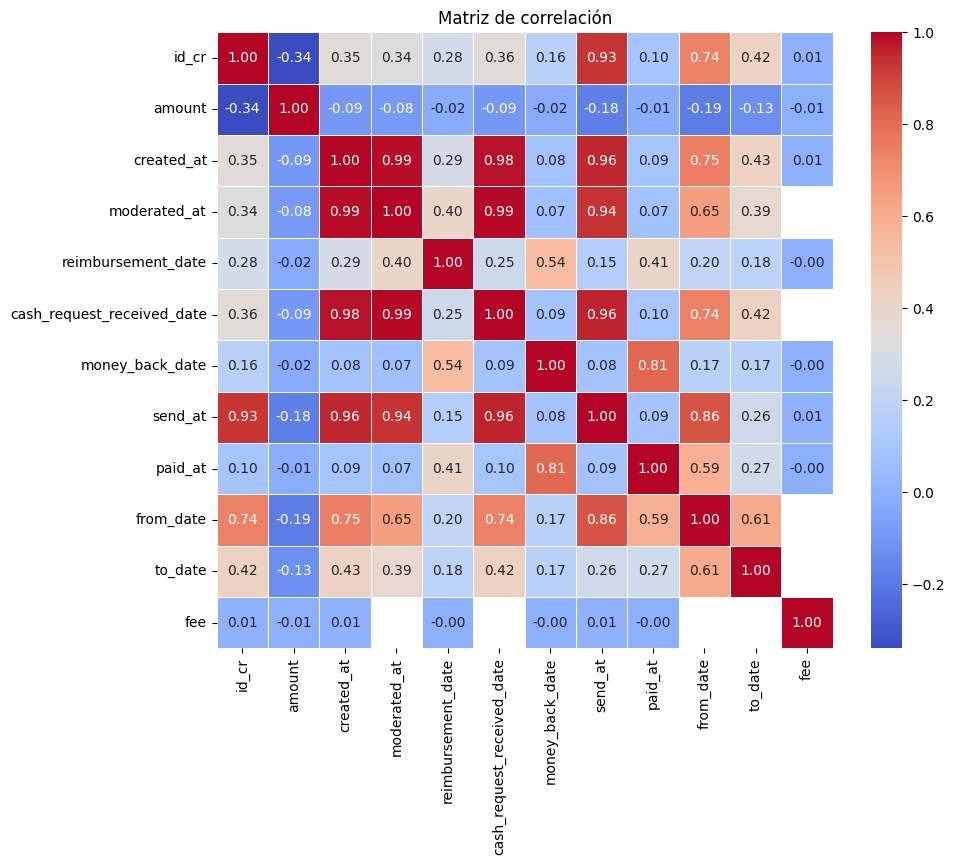

In [3]:
df = pm.df('df_jo')
df = df.drop(columns=['active'])
df = df.drop(columns=['Mes_created_at'])
#df = df.drop(columns=['fee'])
df = df.drop(columns=['total_amount'])
df = df.drop(columns=['user_id'])

d_list = list(df.select_dtypes(include=['datetime64']).columns)
for date in d_list:
    df[date] = pd.to_datetime(df[date]).dt.strftime('%Y%m%d').astype(float)
df_corr = df.select_dtypes(include=['number'])
matriz_corr = df_corr.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

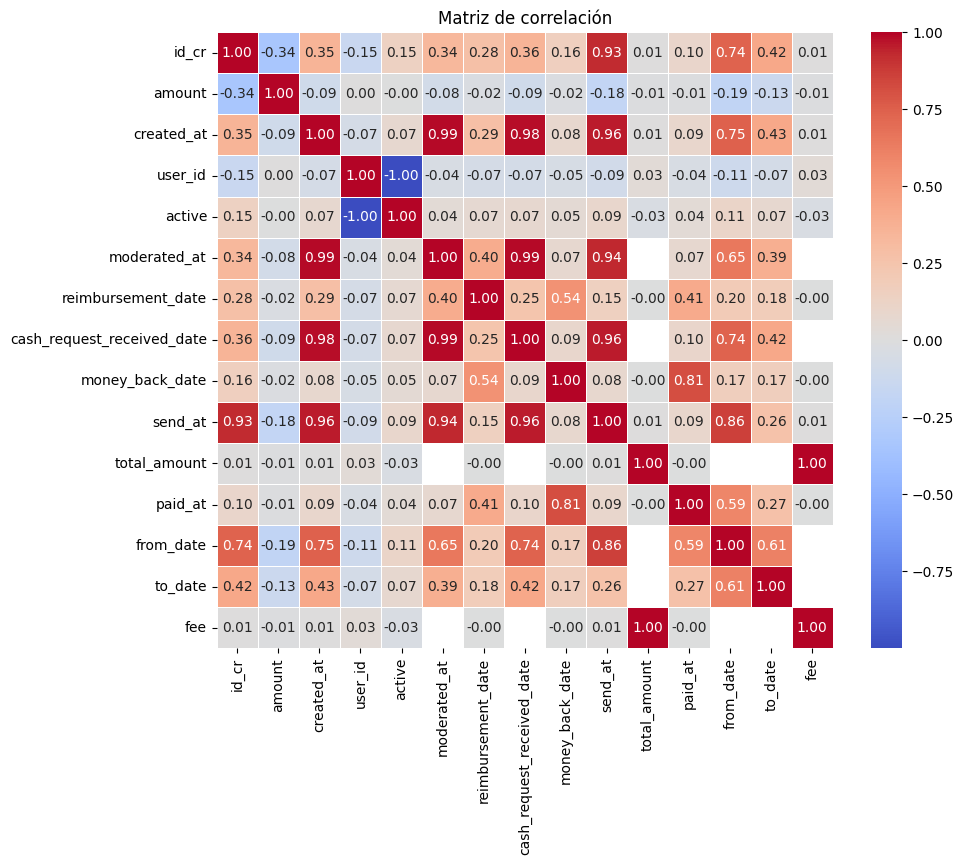

In [7]:
df = pm.df('df_jo')
#df = df.drop(columns=['active'])
#df = df.drop(columns=['Mes_created_at'])
#df = df.drop(columns=['fee'])
#df = df.drop(columns=['total_amount'])
#df = df.drop(columns=['user_id'])

d_list = list(df.select_dtypes(include=['datetime64']).columns)
for date in d_list:
    df[date] = pd.to_datetime(df[date]).dt.strftime('%Y%m%d').astype(float)
df_corr = df.select_dtypes(include=['number'])
matriz_corr = df_corr.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()



In [14]:
df = pm.df('df_jo')

cr_id = ['id_cr','user_id', 'created_at','amount','fee','stat_cr','stat_fe','transfer_type','type',
            'to_receive_ini', 'to_receive_bank','to_reimbur','to_end','to_send','to_delay',
             'send_at', 'cr_received_date', #'money_back_date', 'reimbursement_date',
            'paid_at','charge_moment','moderated_at'] # ,'id_y','from_date','to_date','reason','recovery_status', 'cash_request_id'

# print("Casos segun Cash Request ID")
# for id in ([ 23534]): # 20108, 20104, 20112,
#     df_t = df[df['id_cr'] == id].reset_index()
#     print(f"Cash Request ID: {id}")
#     display(df_t[cr_id].sort_values('created_at'))

user_ids = [430,  63894,18730,10116,21465, 99000262]

print("Casos segun Cash User ID")
for id in (user_ids):
    df_t = df[df['user_id'] == id].reset_index()
    print(f"User ID: {id}")
    display(df_t[cr_id].sort_values('created_at'))

Casos segun Cash User ID
User ID: 430


KeyError: "['to_receive_ini', 'to_receive_bank', 'to_reimbur', 'to_end', 'to_send', 'to_delay', 'cr_received_date'] not in index"

In [ ]:
classification_colors = {'null': 'blue', 'instant_payment':'green', 'postpone':'orange', 'incident':'red'}
#df['created_at_w'] = df['created_at']# .dt.to_period('W').astype(str)
df= df.dropna(subset=['to_end'])
df= df.dropna(subset=['type'])
x_values = df['id_cr']
y_values = df['to_end'].dt.days # .astype('int')
c_values= list(df['type'].map(classification_colors))
fig, ax= plt.subplots(figsize=(12,6))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .4)
plt.title('Retraso al devolver el prestamo: created_at vs to_end (reimbursement_date - money_back_date)')
plt.xlabel('cash_request id_cr')
plt.ylabel('Dias de retraso')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

In [ ]:
classification_colors = {'null': 'blue', 'instant_payment':'green', 'postpone':'orange', 'incident':'red'}
#df['created_at_w'] = df['created_at']# .dt.to_period('W').astype(str)
df= df.dropna(subset=['to_end'])
df= df.dropna(subset=['type'])
x_values = df['created_at'] #'id_cr']
y_values = df['to_end'].dt.days # .astype('int')
c_values= list(df['type'].map(classification_colors))
fig, ax= plt.subplots(figsize=(12,6))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .4)
plt.title('Retraso al devolver el prestamo: created_at vs to_end (reimbursement_date - money_back_date)')
plt.xlabel('cash_request created_at')
plt.ylabel('Dias de retraso')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

In [ ]:
classification_colors = {'null': 'blue', 'instant_payment':'green', 'postpone':'orange', 'incident':'red'}
#df['created_at_w'] = df['created_at']# .dt.to_period('W').astype(str)
df= df.dropna(subset=['to_end'])
df= df.dropna(subset=['type'])
x_values = df['created_at'] #'id_cr']
y_values = df['to_end'].dt.days # .astype('int')
c_values= list(df['type'].map(classification_colors))
fig, ax= plt.subplots(figsize=(12,6))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = .4)
plt.title('Retraso al devolver el prestamo: created_at vs to_end (reimbursement_date - money_back_date)')
plt.xlabel('cash_request created_at')
plt.ylabel('Dias de retraso')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
#df_jo.info()
#display(df_jo)

df_t = df_jo.copy()
df_t['Mes_created_at_d'] = df_t['created_at'].dt.to_period('d').astype(str)
df_t['Mes_created_at_w'] = df_t['created_at'].dt.to_period('W-WED').astype(str)
df_t['Mes_created_at_m'] = df_t['created_at'].dt.to_period('M').astype(str)

fig, ax= plt.subplots(figsize=(12,2))
plt.title('amount vs fee (mean) days')
ratio_bag=df_t.groupby('Mes_created_at_d')[['amount', 'fee']].mean()
ratio_bag.plot(kind='line', color=['green', 'orange'],ax=ax )
plt.show()

fig, ax= plt.subplots(figsize=(12,2))
plt.title('amount vs fee (mean) weeks')
ratio_bag=df_t.groupby('Mes_created_at_w')[['amount', 'fee']].mean()
ratio_bag.plot(kind='bar', color=['green', 'orange'],ax=ax )
plt.show()

# fig, ax= plt.subplots(figsize=(12,2))
# plt.title('amount vs fee (mean) months')
# ratio_bag=df_t.groupby('Mes_created_at_m')[['amount', 'fee']].mean()
# ratio_bag.plot(kind='bar', color=['green', 'orange'],ax=ax )
# plt.show()

fig, ax= plt.subplots(figsize=(12,2))
plt.title('amount vs fee (sum) days (log)')
ratio_bag=df_t.groupby('Mes_created_at_d')[['amount', 'fee']].sum()
ratio_bag.plot(kind='line', color=['green', 'orange'],ax=ax )
plt.yscale('log')
plt.show()

fig, ax= plt.subplots(figsize=(12,2))
plt.title('amount vs fee (sum) weeks (log)')
ratio_bag=df_t.groupby('Mes_created_at_w')[['amount', 'fee']].sum()
ratio_bag.plot(kind='bar', color=['green', 'orange'],ax=ax )
plt.yscale('log')
plt.show()

In [ ]:
classification_colors = {'null': 'blue', 'instant_payment':'green', 'postpone':'orange', 'incident':'red'}
df_t = df_jo.copy()
df_t= df_t.dropna(subset=['type'])

#df_t['created_at_w'] = df_t['created_at']# .dt.to_period('W').astype(str)
df_filter = df_t
fig, ax= plt.subplots(figsize=(20,2))
x_values = df_filter['created_at']
y_values = df_filter['amount'] # fee
c_values= list(df_filter['type'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1.)
plt.title('transfer_type: all')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

df_t['created_at_w'] = df_t['created_at']# .dt.to_period('W').astype(str)
df_filter = df_t[df_t['transfer_type']=='instant']
#display(df_filter)
fig, ax= plt.subplots(figsize=(20,2))
x_values = df_filter['created_at_w']
y_values = df_filter['amount'] # fee
c_values= list(df_filter['type'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1.)
plt.title('transfer_type: instant')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

df_t['created_at_w'] = df_t['created_at']# .dt.to_period('W').astype(str)
df_filter = df_t[df_t['transfer_type']=='regular']
#display(df_filter)
fig, ax= plt.subplots(figsize=(20,2))
x_values = df_filter['created_at_w']
y_values = df_filter['amount'] # fee
c_values= list(df_filter['type'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1.)
plt.title('transfer_type: regular')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

In [ ]:
df_t = df_jo.copy()
#grouped = df_t.groupby(['type'])
df_t['type'] = df_t['type'].fillna('null')
#df_t= df_t.dropna(subset=['type'])

df_t['created_at_w'] = df_t['created_at']# .dt.to_period('W').astype(str)
df_filter = df_t
fig, ax= plt.subplots(figsize=(20,2))
x_values = df_filter['created_at_w']
y_values = df_filter['amount'] # fee
c_values= list(df_filter['type'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1.)
plt.title('transfer_type: all')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

df_t['created_at_w'] = df_t['created_at']# .dt.to_period('W').astype(str)
df_filter = df_t[df_t['transfer_type']=='instant']
#display(df_filter)
fig, ax= plt.subplots(figsize=(20,2))
x_values = df_filter['created_at_w']
y_values = df_filter['amount'] # fee
c_values= list(df_filter['type'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1.)
plt.title('transfer_type: instant')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

df_t['created_at_w'] = df_t['created_at']# .dt.to_period('W').astype(str)
df_filter = df_t[df_t['transfer_type']=='regular']
#display(df_filter)
fig, ax= plt.subplots(figsize=(20,2))
x_values = df_filter['created_at_w']
y_values = df_filter['amount'] # fee
c_values= list(df_filter['type'].map(classification_colors))
plt.scatter(x= x_values, y= y_values, c=c_values, alpha = 1.)
plt.title('transfer_type: regular')
legend_patches = [mpatches.Patch(color=color, label=type) for type, color in classification_colors.items()]
plt.legend(handles=legend_patches, loc='best', title ='fees type') #upper right')
plt.grid()
plt.show()

In [ ]:
#cash_request=pd.read_csv('../data/extract - cash request - data analyst.csv')
#fees=pd.read_csv('../data/extract - fees - data analyst - .csv')
df_jo = pm.df('df_jo')

fig1 = px.imshow(df_jo.isnull(),
color_continuous_scale=['black', 'red'],
labels=dict(color="NaN"),
title="Mapa de calor para cash_request join fees")
fig1.update_layout(width=700, height=700)
fig1.update_coloraxes(showscale=False)
fig1.show()


In [ ]:
# Visualización de distribuciones de datos
columnas_numericas_cash_request=df_jo.describe().columns.tolist()
for c in columnas_numericas_cash_request:
    fig = px.histogram(df_jo, x=c, title=f'Histograma de {c}')
    fig.update_layout(height=500)
    fig.show()